# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [2]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,5.740803,1.0
1,3.282981,-1.0
2,1.362993,1.0
3,3.615957,1.0
4,1.805005,1.0
...,...,...
995,1.915010,1.0
996,1.611996,1.0
997,6.613739,1.0
998,0.931998,-1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model
Simplest usage of HSSM, only data needs to be provided.

In [3]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)	bounds: (-3.0, 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

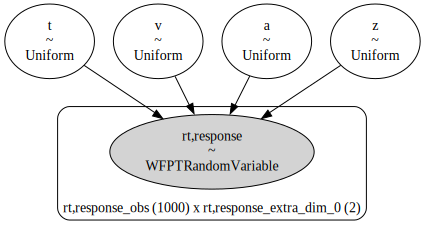

In [4]:
simple_ddm_model.graph()

In [5]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, t, z, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

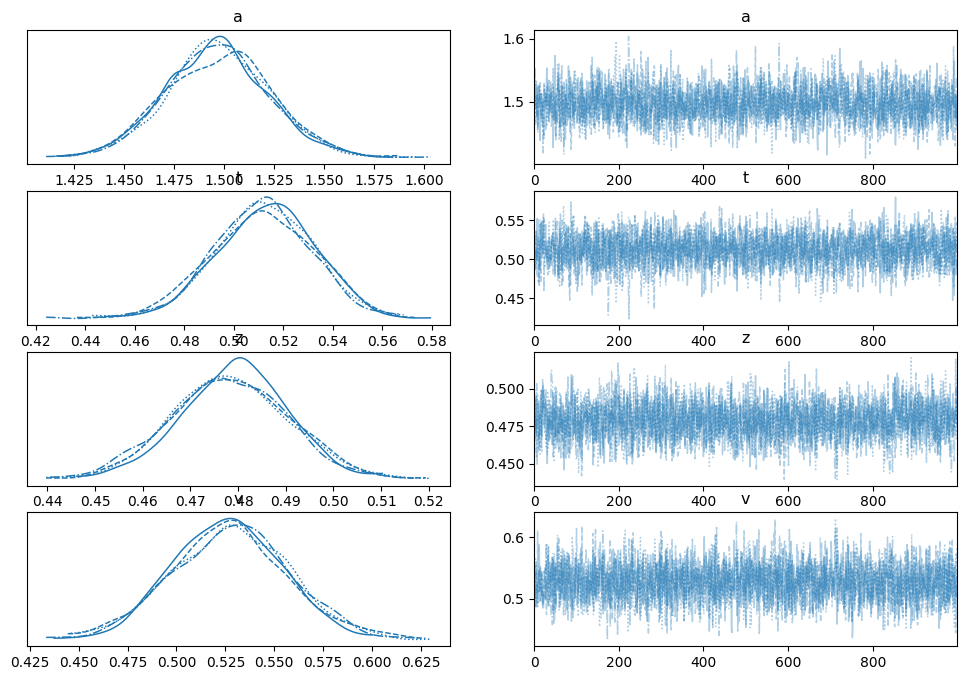

In [6]:
az.plot_trace(simple_ddm_model.traces);

In [7]:
az.summary(simple_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.497,0.026,1.448,1.547,0.001,0.0,2514.0,3015.0,1.0
t,0.512,0.020,0.475,0.550,0.000,0.0,2317.0,2516.0,1.0
z,0.479,0.012,0.454,0.499,0.000,0.0,2413.0,2358.0,1.0
v,0.527,0.030,0.472,0.583,0.001,0.0,2723.0,2532.0,1.0


In [8]:
simple_ddm_model.model.predict()

TypeError: predict() missing 1 required positional argument: 'idata'

## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [ ]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

This creates a default angle model using pytensor

In [ ]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

In [ ]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

In [ ]:
az.plot_trace(angle_model.traces);

#### Sampling the angle model using jax

In [ ]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

In [ ]:
az.summary(angle_model.traces)

### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [ ]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.2, 0.5, size=1000)
y = np.random.uniform(0.1, 0.4, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [ ]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

In [ ]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [ ]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

In [ ]:
model_reg_v.graph()

In [ ]:
trace_reg_v = model_reg_v.sample(cores=1, chains=2, draws=500)

In [ ]:
az.plot_trace(model_reg_v.traces)

In [ ]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

In [ ]:
new_data = pd.DataFrame(
    {
        "x": np.random.uniform(0.2, 0.5, size=1000),
        "y": np.random.uniform(0.1, 0.4, size=1000),
    }
)

In [ ]:
posterior = model_reg_v.model.predict(model_reg_v.traces, data=new_data, inplace=False)

In [ ]:
az.plot_trace(posterior)

In [ ]:
posterior = model_reg_v.model.predict(
    model_reg_v.traces, data=new_data, inplace=False, kind="pps"
)

In [ ]:
model_reg_v.traces.posterior

#### Case 2: adding initval to priors along with lower and upper.

- v is a parent
- x is a feature from the dataset_reg_v

Adding initval is optional.

In [ ]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [ ]:
hssm_include_val

In [ ]:
samples_two = hssm_include_val.sample()

In [ ]:
az.summary(samples_two)

#### Case 3: not specifying parent v in the include parameter. 

The parent is v by default, specifying it is not mandatory. 

In [ ]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [ ]:
hssm_include_val

In [ ]:
hssm_include_val.graph()

In [ ]:
samples_three = hssm_include_val.sample(draws=500, tune=500)

In [ ]:
az.summary(samples_three)

#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [ ]:
hssm_include_list.model

In [ ]:
hssm_include_list.graph()

In [ ]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [ ]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [ ]:
samples_three = hssm_include_list.sample(draws=100, tune=100)